# Install required packages

In [1]:
!pip3 install -U timm torchvision > /dev/null

# Load medatadata

In [2]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("../input/amazon-bin-image-dataset-536434-images-224x224/metadata.db")
df = pd.read_sql_query("SELECT name, json_extract(metadata, '$.EXPECTED_QUANTITY') quantity FROM metadata WHERE quantity < 2", conn)
conn.close()
df

,name,quantity
0,1.jpg,0
1,2.jpg,0
2,3.jpg,0
3,4.jpg,0
4,5.jpg,0
...,...,...
51243,535178.jpg,1
51244,535185.jpg,0
51245,535192.jpg,1
51246,535196.jpg,1


# Check class distribution

<AxesSubplot:>

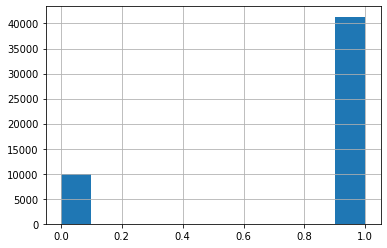

In [3]:
df.quantity.hist()

In [4]:
CLASS_WEIGHTS = df.groupby(['quantity'])['quantity'].count()
CLASS_WEIGHTS

quantity
0     9901
1    41347
Name: quantity, dtype: int64

# Split train and test dataset

In [5]:
import numpy as np
train_all, test_all = np.split(df.sample(frac=1), [int(.9*len(df))])

# Create loader function with WeightedRandomSampler

In [6]:
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import WeightedRandomSampler
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

class MyDataset(Dataset):
    def __init__(self, X, y, directory, transform):
        self.X = X
        self.y = y
        self.N = len(y)
        self.directory = directory
        self.transform = transform
    
    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        image = self.transform(Image.open('{}{}'.format(self.directory, self.X.iloc[idx, 0])))
        return [image, self.y.iloc[idx]]
    
def loader(X, y, transforms):
    ds = MyDataset(X, y, '../input/amazon-bin-image-dataset-536434-images-224x224/bin-images-224x224/bin-images-224x224/', transforms)
    sample_weights = [0] * len(y)
    for idx, label in enumerate(y):
        sample_weights[idx] = CLASS_WEIGHTS[label]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights))
    return DataLoader(ds, batch_size=256, num_workers=2, sampler=sampler)

# Data Augumentation

In [7]:
import torchvision
from torchvision import transforms as T

train_transforms = T.Compose([
    T.RandomHorizontalFlip(p=0.1),
    T.RandomGrayscale(p=0.1),
    T.RandomAdjustSharpness(2, p=0.1),
    T.RandomAutocontrast(p=0.1),
    T.RandomApply([T.ColorJitter(0.5, 0.5, 0.5, 0.5)], p=0.1),
    T.RandomApply([T.RandomAffine(degrees=0, translate=(0, 0.02), scale=(0.95, 0.99))], p=0.1),
    T.RandomApply([T.RandomChoice([
        T.RandomRotation((90, 90)),
        T.RandomRotation((-90, -90)),
    ])], p=0.1),
    T.ToTensor(),
])

valid_transforms = T.Compose([
    T.ToTensor(),
])

# Model Design

In [8]:
import timm
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def net(name, pretrained=True):
    model = timm.create_model(name, pretrained)
    for param in model.parameters():
        param.requires_grad = False

    layer = nn.Sequential(
        nn.BatchNorm1d(model.get_classifier().in_features),
        nn.Linear(model.get_classifier().in_features, 512, bias=False),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.5, inplace=True),
        nn.Linear(512, 2, bias=False))
    if name.startswith('resnet'):
        model.fc = layer
    else: # efficientnet
        model.classifier = layer
    return model

# Define validate and train functions

In [9]:
import sys
from tqdm import tqdm

def validate(model, data_loader):
    model.eval()
    running_corrects=0
    for (inputs, labels) in tqdm(data_loader, 'Validate', file=sys.stdout):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data).item()
        
    total_acc = 100.0 * running_corrects / len(data_loader.dataset)
    print("Average accuracy: %f" % total_acc)
    return total_acc

def train(model, train_loader, valid_loader, epochs, optimizer):
    criterion = nn.CrossEntropyLoss()
    model.train()
    previous_accuracy = 0
    for e in range(1, epochs+1):
        train_loss = 0
        for (inputs, labels) in tqdm(train_loader, 'Epoch %s' % e, file=sys.stdout):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f'Loss: {train_loss / len(train_loader)}')
    return model

# Train models (You can skip this and download the pretrained ones)
- Use `efficientnet_b0`
- Use `StratifiedKFold`
- Use `Multi-Resolution` training
- Use `Adam optimizer` with weight decay 1e-4

In [ ]:
from torch.optim import Adam
from sklearn.model_selection import StratifiedKFold

name = 'efficientnet_b0'
models = []
IMAGE_SIZES = [56, 112, 224]
EPOCHS = 10

X = train_all.drop('quantity', axis=1)
y = train_all.quantity
skf = StratifiedKFold(n_splits=10)

for i, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f'FOLD {i}')
    t = loader(X.iloc[train_idx], y.iloc[train_idx], train_transforms)
    v = loader(X.iloc[valid_idx], y.iloc[valid_idx], valid_transforms)
    model = net(name).to(device)
    for s in IMAGE_SIZES:
        optimizer = Adam(model.get_classifier().parameters(), weight_decay=1e-4)
        model = train(model, t, v, EPOCHS, optimizer)

    models.append(model)

# Download pre-trained image

In [12]:
!git clone https://github.com/williamhyun/models.git

Cloning into 'models'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 16 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), 39.56 MiB | 3.20 MiB/s, done.


In [14]:
!ls models

LICENSE    model0  model2  model4  model6  model8
README.md  model1  model3  model5  model7  model9


In [16]:
# Load models
name = 'efficientnet_b0'
models = []
for i in range(10):
    model = net(name)
    model.load_state_dict(torch.load("models/model%s" % i))
    model.to(device)
    model.eval()
    models.append(model)

# Test

In [17]:
X = test_all.drop('quantity', axis=1)
y = test_all.quantity

test_dataset = MyDataset(X, y, '../input/amazon-bin-image-dataset-536434-images-224x224/bin-images-224x224/bin-images-224x224/', valid_transforms)
test_loader  = DataLoader(test_dataset, batch_size=256, num_workers=2)

for model in models:
    model.eval()

running_corrects=0
for (inputs, labels) in tqdm(test_loader, 'Test', file=sys.stdout):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = torch.mean(torch.stack([m(inputs) for m in models]), dim=0)
    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data).item()
accuracy = 100.0 * running_corrects / len(test_loader.dataset)

print("Average accuracy: %f" % accuracy)

Test: 100%|██████████| 21/21 [00:38<00:00,  1.82s/it]
Average accuracy: 98.263415
